In [1]:
import cv2
import os
import numpy as np
from tqdm import tqdm

# Đường dẫn 3 thư mục riêng biệt từ Kaggle Datasets
input_paths = {
    "with_mask": "/kaggle/input/with-mask",
    "without_mask": "/kaggle/input/without-mask",
    "mask_weared_incorrect": "/kaggle/input/mask-weared-incorrect"
}

# Thư mục output sau xử lý
output_root = "/kaggle/working/my-phone-photos-processed"
os.makedirs(output_root, exist_ok=True)

# Load model res10
prototxt_path = "/kaggle/input/res10-face-detector/deploy.prototxt"
weights_path = "/kaggle/input/res10-face-detector/res10_300x300_ssd_iter_140000.caffemodel"
face_net = cv2.dnn.readNetFromCaffe(prototxt_path, weights_path)

# Kích thước ảnh đầu ra
target_size = (224, 224)

def detect_and_crop_face(image_path):
    image = cv2.imread(image_path)
    if image is None:
        return None

    h, w = image.shape[:2]
    blob = cv2.dnn.blobFromImage(image, 1.0, (300, 300), (104.0, 177.0, 123.0))
    face_net.setInput(blob)
    detections = face_net.forward()

    max_conf = 0
    box = None
    for i in range(detections.shape[2]):
        confidence = detections[0, 0, i, 2]
        if confidence > max_conf and confidence > 0.5:
            box = detections[0, 0, i, 3:7] * np.array([w, h, w, h])
            max_conf = confidence

    if box is not None:
        (x1, y1, x2, y2) = box.astype("int")
        face = image[y1:y2, x1:x2]
        if face.size == 0:
            return None
        face_resized = cv2.resize(face, target_size)
        return face_resized
    return None

# Xử lý từng folder
for label, folder_path in input_paths.items():
    output_folder = os.path.join(output_root, label)
    os.makedirs(output_folder, exist_ok=True)

    for filename in tqdm(os.listdir(folder_path), desc=f"Processing {label}"):
        input_path = os.path.join(folder_path, filename)
        output_path = os.path.join(output_folder, filename)

        face_img = detect_and_crop_face(input_path)
        if face_img is not None:
            cv2.imwrite(output_path, face_img)


Processing mask_weared_incorrect: 100%|██████████| 9/9 [00:00<00:00, 23.44it/s]


In [2]:
from PIL import Image
import os

input_dir = "/kaggle/working/my-phone-photos-processed"
output_dir = input_dir  # Ghi đè trong chính thư mục đó
classes = ["with_mask", "without_mask", "mask_weared_incorrect"]

for cls in classes:
    cls_path = os.path.join(input_dir, cls)
    for fname in os.listdir(cls_path):
        name, ext = os.path.splitext(fname)
        if ext.lower() == ".jpg":
            img_path = os.path.join(cls_path, fname)
            img = Image.open(img_path).convert("RGB")  # Chuyển sang RGB để đảm bảo
            new_name = f"{name}.png"
            new_path = os.path.join(cls_path, new_name)
            img.save(new_path, "PNG")
            os.remove(img_path)  # Xoá ảnh gốc .jpg nếu muốn


In [3]:
import os
import shutil

# Thư mục từ dataset gốc
dataset_base = "/kaggle/input/face-mask-detection/Dataset"

# Thư mục từ ảnh tự chụp (bạn đổi tên đúng theo đường dẫn của bạn)
my_phone_dataset = "/kaggle/working/my-phone-photos-processed"

# Nơi sẽ chứa toàn bộ ảnh đã gộp
merged_dataset = "/kaggle/working/merged-dataset"
os.makedirs(merged_dataset, exist_ok=True)

# Tên các class
classes = ["with_mask", "without_mask", "mask_weared_incorrect"]

for cls in classes:
    dst_dir = os.path.join(merged_dataset, cls)
    os.makedirs(dst_dir, exist_ok=True)

    # Gộp từ dataset gốc
    src_dir_1 = os.path.join(dataset_base, cls)
    for filename in os.listdir(src_dir_1):
        src_path = os.path.join(src_dir_1, filename)
        dst_path = os.path.join(dst_dir, filename)
        base, ext = os.path.splitext(filename)
        count = 1
        while os.path.exists(dst_path):
            dst_path = os.path.join(dst_dir, f"{base}_{count}{ext}")
            count += 1
        shutil.copy2(src_path, dst_path)

    # Gộp từ ảnh điện thoại
    src_dir_2 = os.path.join(my_phone_dataset, cls)
    if os.path.exists(src_dir_2):
        for filename in os.listdir(src_dir_2):
            src_path = os.path.join(src_dir_2, filename)
            dst_path = os.path.join(dst_dir, filename)
            base, ext = os.path.splitext(filename)
            count = 1
            while os.path.exists(dst_path):
                dst_path = os.path.join(dst_dir, f"{base}_{count}{ext}")
                count += 1
            shutil.copy2(src_path, dst_path)

print("✅ Dữ liệu từ cả 2 bộ đã được gộp vào /kaggle/working/merged-dataset/")

✅ Dữ liệu từ cả 2 bộ đã được gộp vào /kaggle/working/merged-dataset/


In [4]:
import shutil

shutil.make_archive("/kaggle/working/merged-dataset", 'zip', "/kaggle/working/merged-dataset")
print("✅ Đã nén thư mục thành 'merged-dataset.zip'")

✅ Đã nén thư mục thành 'merged-dataset.zip'


In [5]:
for cls in classes:
    folder = os.path.join(merged_dataset, cls)
    print(f"{cls}: {len(os.listdir(folder))} ảnh")

with_mask: 3000 ảnh
without_mask: 2997 ảnh
mask_weared_incorrect: 3003 ảnh


In [6]:
import os
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.preprocessing import image
from keras import layers
from glob import glob
import keras

2025-04-17 06:18:31.303069: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1744870711.529570      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1744870711.596256      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [7]:
import os
from collections import Counter

# Đường dẫn thư mục gộp
merged_dataset = "/kaggle/working/merged-dataset"

# Tên các class
classes = ["with_mask", "without_mask", "mask_weared_incorrect"]

# Bộ đếm định dạng ảnh
ext_counter = Counter()

for cls in classes:
    cls_dir = os.path.join(merged_dataset, cls)
    if os.path.exists(cls_dir):
        for filename in os.listdir(cls_dir):
            ext = os.path.splitext(filename)[1].lower()
            ext_counter[ext] += 1

print("📸 Định dạng ảnh trong merged-dataset:")
for ext, count in ext_counter.items():
    print(f"{ext}: {count} ảnh")


📸 Định dạng ảnh trong merged-dataset:
.png: 9000 ảnh


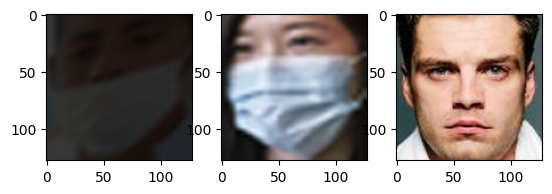

In [8]:
dataset_path = '/kaggle/working/merged-dataset'
mask_weared_incorrect = glob('/kaggle/working/merged-dataset/mask_weared_incorrect/*.png')
with_mask = glob('/kaggle/working/merged-dataset/with_mask/*.png')
without_mask = glob('/kaggle/working/merged-dataset/without_mask/*.png')

# Visualize sample images
fig, ax = plt.subplots(1,3)
ax[0].imshow(plt.imread(mask_weared_incorrect[1]))
ax[1].imshow(plt.imread(with_mask[1]))
ax[2].imshow(plt.imread(without_mask[1]))
plt.show()

Found 7201 images belonging to 3 classes.
Found 1799 images belonging to 3 classes.


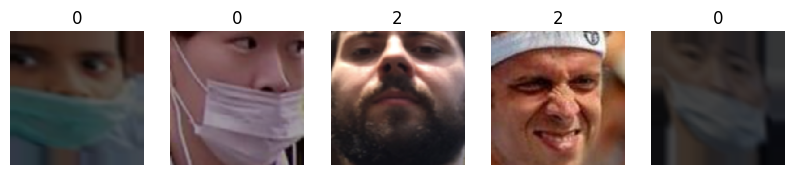

In [9]:
datagen = ImageDataGenerator(
    rescale = 1/255,
    shear_range = 0.2,
    zoom_range = 0.2,
    horizontal_flip = True,
    validation_split = 0.2  # 80% training, 20% validation
)

# Updated image size to (224,224)
train_generator = datagen.flow_from_directory(
    dataset_path,
    target_size = (224, 224),  
    batch_size = 32,
    class_mode = 'categorical',
    subset = 'training'
)

validation_generator = datagen.flow_from_directory(
    dataset_path,
    target_size = (224, 224),  
    batch_size = 32,
    class_mode = 'categorical',
    subset = 'validation'
)

# Visualizing a batch of training images and their labels
x_batch, y_batch = next(train_generator)
plt.figure(figsize=(10,10))
for i in range(5):
    plt.subplot(1,5, i+1)
    plt.imshow(x_batch[i])
    plt.title(np.argmax(y_batch[i]))  # Display class
    plt.axis('off')
plt.show()

In [10]:
base_model = MobileNetV2(input_shape = (224, 224, 3), include_top = False, weights='imagenet')
base_model.trainable = False  # Freeze the base model

# Add custom layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
x = Dense(3, activation='softmax')(x)  # Output 3 classes

model = Model(inputs= base_model.input, outputs = x)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

I0000 00:00:1744870725.228545      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1744870725.229287      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1 (Conv2D)            │ (None, 112, 112, 32)   │            864 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bn_Conv1                  │ (None, 112, 112, 32)   │            128 │ Conv1[0][0]            │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1_relu (ReLU)         │ (None, 112, 112, 32)   │              0 │ bn_Conv1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise   │ (None, 112, 112, 32)   │            288 │ Conv1_relu[0][0]       │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 112, 112, 32)   │            128 │ expanded_conv_depthwi… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 112, 112, 32)   │              0 │ expanded_conv_depthwi… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project     │ (None, 112, 112, 16)   │            512 │ expanded_conv_depthwi… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project_BN  │ (None, 112, 112, 16)   │             64 │ expanded_conv_project… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand (Conv2D)   │ (None, 112, 112, 96)   │          1,536 │ expanded_conv_project… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_BN         │ (None, 112, 112, 96)   │            384 │ block_1_expand[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_relu       │ (None, 112, 112, 96)   │              0 │ block_1_expand_BN[0][… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_pad               │ (None, 113, 113, 96)   │              0 │ block_1_expand_relu[0… │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_depthwise         │ (None, 56, 56, 96)     │            864 │ block_1_pad[0][0]      │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_depthwise_BN 

 Total params: 2,422,339 (9.24 MB)

 Trainable params: 164,355 (642.01 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [11]:
# Define callbacks
checkpoint = ModelCheckpoint('best_model.keras', monitor='val_accuracy', save_best_only=True, mode='max', verbose=1)
early_stop = EarlyStopping(monitor='val_loss', patience=5, verbose=1)

In [12]:
history = model.fit(
    train_generator,
    epochs=20,  # Increased number of epochs
    validation_data=validation_generator,
    callbacks=[checkpoint, early_stop]  # Add callbacks
)

Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1744870738.424130      82 service.cc:148] XLA service 0x7c11f000aeb0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1744870738.425210      82 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1744870738.425237      82 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1744870739.327128      82 cuda_dnn.cc:529] Loaded cuDNN version 90300


  1/226 ━━━━━━━━━━━━━━━━━━━━ 56:31 15s/step - accuracy: 0.1875 - loss: 1.8058

I0000 00:00:1744870743.538908      82 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


225/226 ━━━━━━━━━━━━━━━━━━━━ 0s 314ms/step - accuracy: 0.8665 - loss: 0.3319
Epoch 1: val_accuracy improved from -inf to 0.93774, saving model to best_model.keras
226/226 ━━━━━━━━━━━━━━━━━━━━ 110s 422ms/step - accuracy: 0.8669 - loss: 0.3308 - val_accuracy: 0.9377 - val_loss: 0.1657
Epoch 2/20
225/226 ━━━━━━━━━━━━━━━━━━━━ 0s 302ms/step - accuracy: 0.9567 - loss: 0.1245
Epoch 2: val_accuracy improved from 0.93774 to 0.94497, saving model to best_model.keras
226/226 ━━━━━━━━━━━━━━━━━━━━ 88s 378ms/step - accuracy: 0.9567 - loss: 0.1244 - val_accuracy: 0.9450 - val_loss: 0.1405
Epoch 3/20
225/226 ━━━━━━━━━━━━━━━━━━━━ 0s 300ms/step - accuracy: 0.9701 - loss: 0.0806
Epoch 3: val_accuracy improved from 0.94497 to 0.95220, saving model to best_model.keras
226/226 ━━━━━━━━━━━━━━━━━━━━ 87s 377ms/step - accuracy: 0.9700 - loss: 0.0807 - val_accuracy: 0.9522 - val_loss: 0.1149
Epoch 4/20
225/226 ━━━━━━━━━━━━━━━━━━━━ 0s 301ms/step - accuracy: 0.9756 - loss: 0.0674
Epoch 4: val_accuracy did not impr

In [13]:
# Load the best model
model.load_weights('best_model.keras')

# Evaluate on validation data
loss, accuracy = model.evaluate(validation_generator)
print(f'Validation Accuracy: {accuracy*100:.2f}%')

57/57 ━━━━━━━━━━━━━━━━━━━━ 17s 301ms/step - accuracy: 0.9752 - loss: 0.0781
Validation Accuracy: 97.72%



**Fine-Tuning the Model (Unfreezing MobileNetV2)
We unfreeze the MobileNetV2 base model and fine-tune the entire model with a lower learning rate.
Fine-tuning helps improve the model's performance by allowing it to adjust the weights of pre-trained layers.**


57/57 ━━━━━━━━━━━━━━━━━━━━ 23s 355ms/step


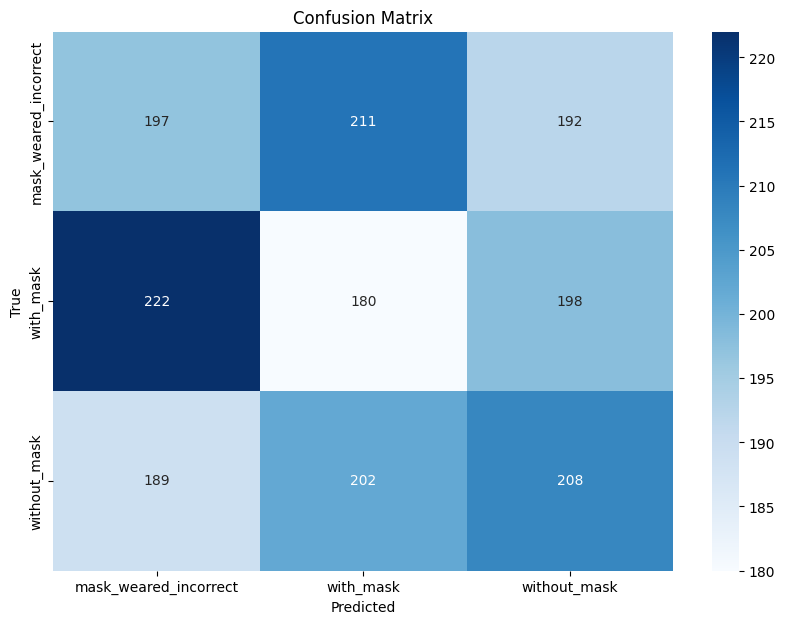

Classification Report:
                        precision    recall  f1-score   support

mask_weared_incorrect       0.32      0.33      0.33       600
            with_mask       0.30      0.30      0.30       600
         without_mask       0.35      0.35      0.35       599

             accuracy                           0.33      1799
            macro avg       0.33      0.33      0.33      1799
         weighted avg       0.33      0.33      0.33      1799



In [14]:
y_true = validation_generator.classes
y_pred = model.predict(validation_generator)
y_pred_classes = np.argmax(y_pred, axis=1)

# Confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred_classes)
# Plot confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=validation_generator.class_indices.keys(), 
            yticklabels=validation_generator.class_indices.keys())
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Classification report
target_names = ['mask_weared_incorrect', 'with_mask', 'without_mask']
print("Classification Report:\n", classification_report(y_true, y_pred_classes, target_names=target_names))

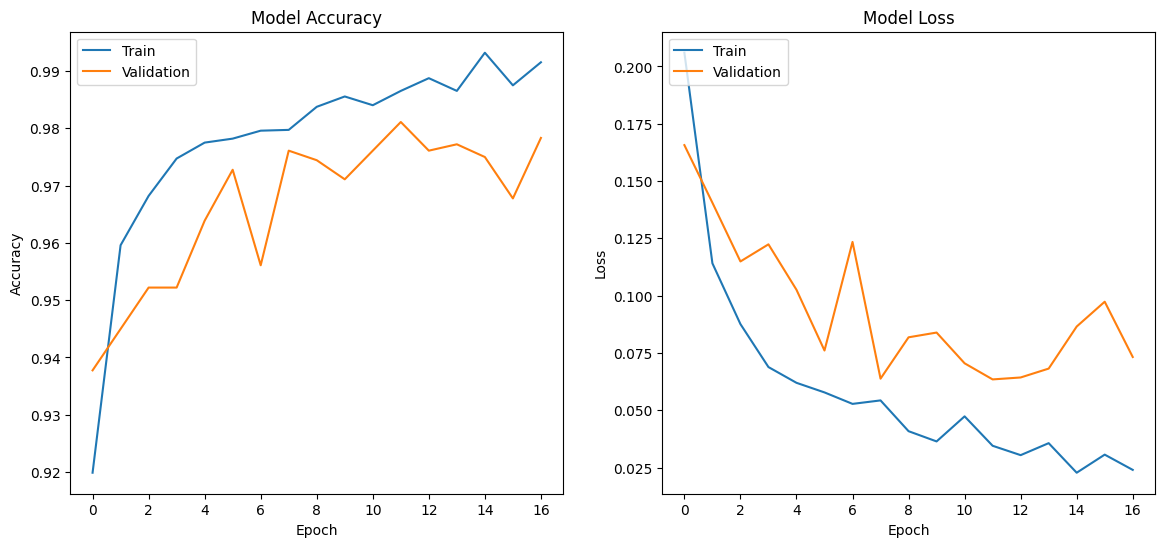

In [15]:
# Plot training & validation accuracy
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


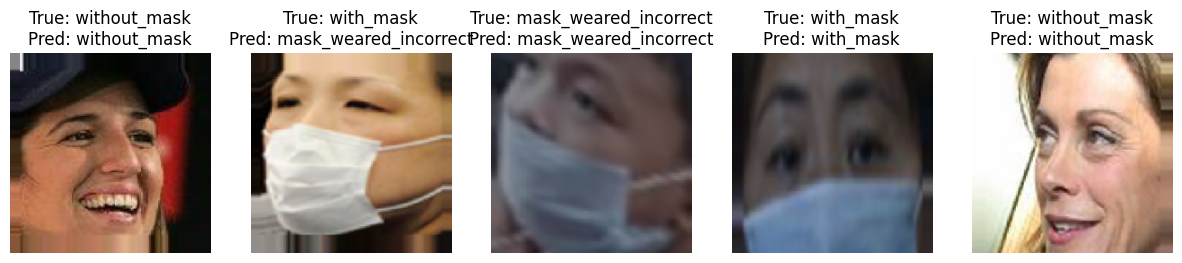

In [16]:
def visualize_predictions(generator, model, num_images=5):
    images, labels = next(generator)
    predictions = model.predict(images)
    predicted_classes = np.argmax(predictions, axis=1)
    true_classes = np.argmax(labels, axis=1)
    class_labels = list(generator.class_indices.keys())

    plt.figure(figsize=(15, 15))
    for i in range(num_images):
        plt.subplot(1, num_images, i + 1)
        plt.imshow(images[i])
        plt.title(f'True: {class_labels[true_classes[i]]}\nPred: {class_labels[predicted_classes[i]]}')
        plt.axis('off')
    plt.show()

visualize_predictions(validation_generator, model)

In [17]:
model.save('/kaggle/working/mask_detection_model.keras')

[INFO] Model loaded ✅
🔍 images.jpg


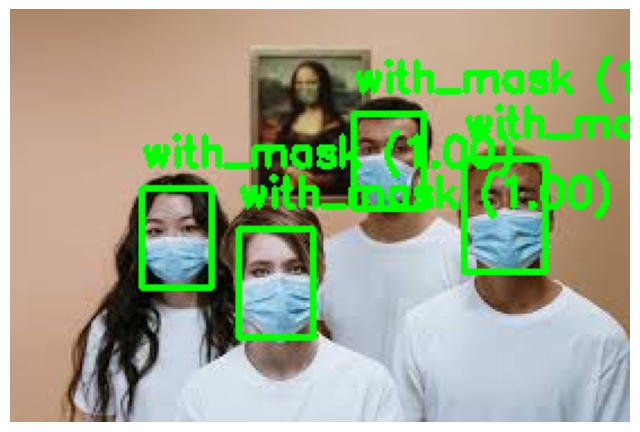

🔍 6.jpg


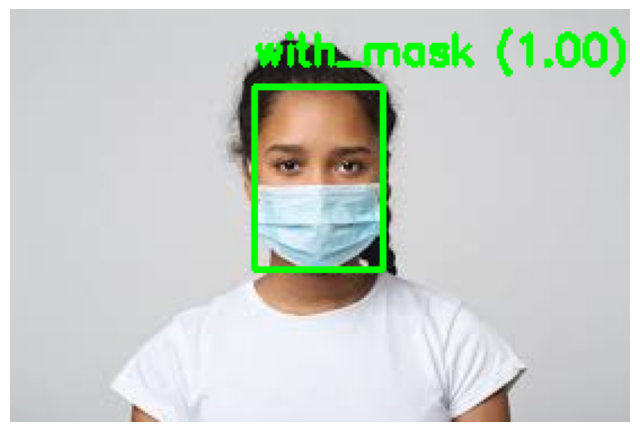

🔍 1.png


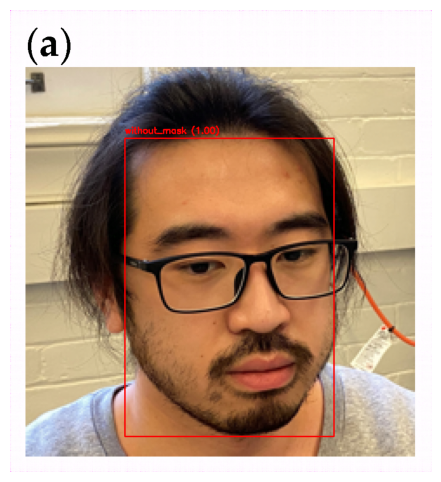

🔍 4.png


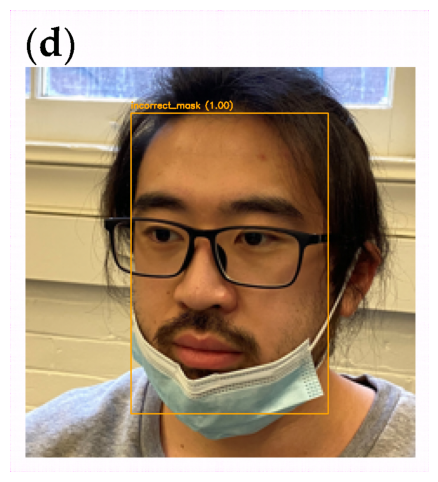

🔍 5.jpg


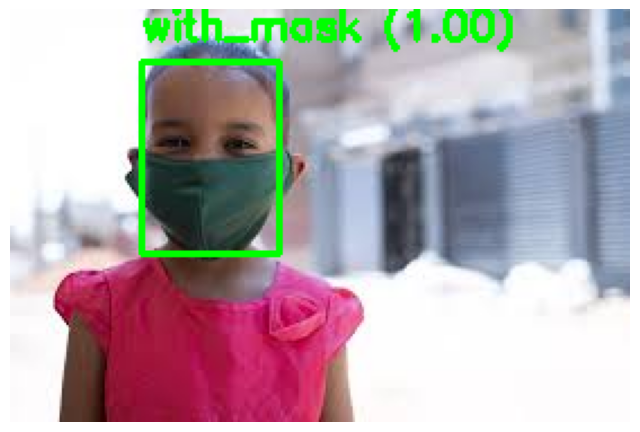

In [18]:
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
import random  # Thêm thư viện random

# === 1. Load model đã train ===
model = load_model("/kaggle/working/best_model.keras")  # Đổi đúng tên thư mục
print("[INFO] Model loaded ✅")

# === 2. Load face detector Res10 ===
prototxt = "/kaggle/input/res10-face-detector/deploy.prototxt"
weights = "/kaggle/input/res10-face-detector/res10_300x300_ssd_iter_140000.caffemodel"
face_net = cv2.dnn.readNetFromCaffe(prototxt, weights)

# === 3. Hàm detect + dự đoán + vẽ ===
def predict_and_draw(image_path, model, face_net, input_size=(224, 224), threshold=0.5):
    image = cv2.imread(image_path)
    orig = image.copy()
    h, w = image.shape[:2]

    blob = cv2.dnn.blobFromImage(image, 1.0, (300, 300), [104, 117, 123])
    face_net.setInput(blob)
    detections = face_net.forward()

    labels = ["incorrect_mask", "with_mask", "without_mask"]
    
    for i in range(detections.shape[2]):
        conf = detections[0, 0, i, 2]
        if conf < threshold:
            continue

        box = detections[0, 0, i, 3:7] * np.array([w, h, w, h])
        (x1, y1, x2, y2) = box.astype("int")

        # Crop và chuẩn hóa khuôn mặt
        face = image[y1:y2, x1:x2]
        if face.size == 0:
            continue

        face = cv2.resize(face, input_size)
        face = face.astype("float32") / 255.0
        face = np.expand_dims(face, axis=0)

        preds = model.predict(face, verbose=0)
        idx = np.argmax(preds[0])
        label = labels[idx]
        score = preds[0][idx]

        # Vẽ bounding box + label
        text = f"{label} ({score:.2f})"
        color = (0, 255, 0) if label == "with_mask" else ((0, 0, 255) if label == "without_mask" else (0, 165, 255))
        cv2.rectangle(orig, (x1, y1), (x2, y2), color, 2)
        cv2.putText(orig, text, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.6, color, 2)

    # Chuyển BGR sang RGB để hiển thị bằng matplotlib
    rgb_img = cv2.cvtColor(orig, cv2.COLOR_BGR2RGB)
    plt.figure(figsize=(8, 6))
    plt.imshow(rgb_img)
    plt.axis("off")
    plt.show()
# Đổi thành tên thư mục bạn upload chứa ảnh
input_dir = "/kaggle/input/testdata"
image_files = [f for f in os.listdir(input_dir) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]

# ✅ Lấy ngẫu nhiên 10 ảnh
random_images = random.sample(image_files, min(5, len(image_files)))  # Tránh lỗi nếu <10 ảnh

for img_name in random_images:
    img_path = os.path.join(input_dir, img_name)
    print(f"🔍 {img_name}")
    predict_and_draw(img_path, model, face_net)


In [19]:
pip install keras-flops

Note: you may need to restart the kernel to use updated packages.


In [20]:
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.python.framework.convert_to_constants import convert_variables_to_constants_v2

# ==== Load model ====
model = load_model("/kaggle/working/best_model.keras")
print("✅ Model loaded")

# ==== Tính FLOPs ====
def get_flops(model, image_size=224):
    full_model = tf.function(lambda x: model(x))
    concrete_func = full_model.get_concrete_function(
        tf.TensorSpec([1, image_size, image_size, 3], tf.float32)
    )
    frozen_func = convert_variables_to_constants_v2(concrete_func)
    graph_def = frozen_func.graph.as_graph_def()

    with tf.Graph().as_default() as graph:
        tf.compat.v1.import_graph_def(graph_def, name="")
        run_meta = tf.compat.v1.RunMetadata()
        opts = tf.compat.v1.profiler.ProfileOptionBuilder.float_operation()
        flops = tf.compat.v1.profiler.profile(graph, run_meta=run_meta, cmd="op", options=opts)
    
    return flops.total_float_ops / 1e9  # GFLOPs

# ==== Tính toán ====
input_size = 224  # Đổi theo model bạn dùng (ví dụ 224, 128,...)
bflops = get_flops(model, input_size)
print(f"📊 Model FLOPs: {bflops:.2f} BFLOPs")


✅ Model loaded


I0000 00:00:1744872311.018571      19 devices.cc:67] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 2
I0000 00:00:1744872311.018807      19 single_machine.cc:361] Starting new session
I0000 00:00:1744872311.021024      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1744872311.021234      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5



=========================Options=============================
-max_depth                  10000
-min_bytes                  0
-min_peak_bytes             0
-min_residual_bytes         0
-min_output_bytes           0
-min_micros                 0
-min_accelerator_micros     0
-min_cpu_micros             0
-min_params                 0
-min_float_ops              1
-min_occurrence             0
-step                       -1
-order_by                   float_ops
-account_type_regexes       .*
-start_name_regexes         .*
-trim_name_regexes          
-show_name_regexes          .*
-hide_name_regexes          
-account_displayed_op_only  true
-select                     float_ops
-output                     stdout:

==================Model Analysis Report======================

Doc:
op: The nodes are operation kernel type, such as MatMul, Conv2D. Graph nodes belonging to the same type are aggregated together.
flops: Number of float operations. Note: Please read the implementation for th